# A simple Moon tracker based on mask-RCNN


#### Customized by : Praveen Vijayan                                                                                   
#### Inspired from : https://towardsdatascience.com/object-detection-using-mask-r-cnn-on-a-custom-dataset-4f79ab692f6d 
#### Inspired from : https://github.com/matterport/Mask_RCNN                                                           

In [1]:
# Tensowflow and keras may have some version issues. As some the function calls from '/matterport/Mask_RCNN' 
# is of old version. Create your enviornmnet accordingly else you have to modify inside the actual functions.
# Recommended to use tensorflow 1.4+ and Keras 2.0.8+. 

In [2]:
# works in Colab
%tensorflow_version 1.x

ERROR:root:Line magic function `%tensorflow_version` not found.


# Import libraries

In [3]:
import warnings
warnings.filterwarnings('ignore')
from mrcnn.config import Config
from mrcnn import model as modellib
from mrcnn import visualize
import mrcnn
from mrcnn.utils import Dataset
from mrcnn.model import MaskRCNN
import numpy as np
from numpy import zeros
from numpy import asarray
import colorsys
import argparse
import imutils
import random
import cv2
import os
import time
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from keras.models import load_model
%matplotlib inline
from os import listdir
from xml.etree import ElementTree

Using TensorFlow backend.


# Customize config of our object detection 

In [4]:
class moon_detector_Config(Config):
    # give the configuration a recognizable name
    NAME = "moon_detector_Config"
 
    # set the number of GPUs to use along with the number of images
    # per GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
 
    # number of classes (we would normally add +1 for the background)
     # moon + BG
    NUM_CLASSES = 1+1
   
    # Number of training steps per epoch
    STEPS_PER_EPOCH = 50
    
    # Learning rate
    LEARNING_RATE=0.001
    
    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.95
    
    # setting Max ground truth instances
    MAX_GT_INSTANCES=1   
    
    # Maximum instances in a frame. Only one moon possible. 
    # But can have different number based on the object example cat, dog, bus, car etc.
    DETECTION_MAX_INSTANCES = 1

In [5]:
config = moon_detector_Config()

In [6]:
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        1
DETECTION_MIN_CONFIDENCE       0.95
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_mask_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'rpn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

# Create a dataset of your object. 
### Create Mask for each object on the dataset to be created using labellmg or similar tool.
### Save the annotations in an xml file.

In [7]:
class MoonDataset(Dataset):
    # load the dataset definitions
    def load_dataset(self, dataset_dir, is_train=True):
        
        # Add classes. We have only one class to add.
        self.add_class("dataset", 1, "moon")
        
        
        ######################################################################################
        # define data locations for images and annotations
        images_dir = 'moon_mask_full/images/'
        annotations_dir = 'moon_mask_full/annotations/'
        ######################################################################################
        
        annot_list = []
        for annot in listdir(annotations_dir):
              annot_list.append(annot.split('.')[0])
                
        # Iterate through all files in the folder to 
        #add class, images and annotaions 
        for filename in listdir(images_dir):
            
            
            # extract image id for all formats like jpg / png / jpeg ...
            image_id =    filename.split('.')[0]    
            #print(image_id)
            
            # There can be a chance that you don't created xml file for all the images. 
            # To filter images which have corresponding mask XML file.
                

            if image_id != '' and image_id in annot_list:
              # setting image file
              img_path = images_dir + filename
              #print(img_path)
              # setting annotations file
              ann_path = annotations_dir + image_id + '.xml'
              #print(ann_path)
              # adding images and annotations to dataset
              self.add_image('dataset', image_id=image_id, path=img_path, annotation=ann_path)
    
    # extract bounding boxes from an annotation file
    def extract_boxes(self, filename):
        
        # load and parse the file
        tree = ElementTree.parse(filename)
        # get the root of the document
        root = tree.getroot()
        # extract each bounding box
        boxes = list()
        for box in root.findall('.//bndbox'):
            xmin = int(box.find('xmin').text)
            ymin = int(box.find('ymin').text)
            xmax = int(box.find('xmax').text)
            ymax = int(box.find('ymax').text)
            coors = [xmin, ymin, xmax, ymax]
            boxes.append(coors)
        
        # extract image dimensions
        width = int(root.find('.//size/width').text)
        height = int(root.find('.//size/height').text)

        #print(boxes, width, height)
        return boxes, width, height
    
    # load the masks for an image
    """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
     """
    def load_mask(self, image_id):
        # get details of image
        info = self.image_info[image_id]
        #print(info)
        # define anntation  file location
        path = info['annotation']
        
        # load XML
        boxes, w, h = self.extract_boxes(path)
       
        # create one array for all masks, each on a different channel
        masks = zeros([h, w, len(boxes)], dtype='uint8')
        
        # create masks
        class_ids = list()
        for i in range(len(boxes)):
            box = boxes[i]
            row_s, row_e = box[1], box[3]
            col_s, col_e = box[0], box[2]
            masks[row_s:row_e, col_s:col_e, i] = 1
            class_ids.append(self.class_names.index('moon'))
        return masks, asarray(class_ids, dtype='int32')
    
    # load an image reference
    """Return the path of the image."""
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        #print(info)
        return info['path']

# Load the dataset 

In [8]:
# prepare train set
train_set = MoonDataset()
train_set.load_dataset( 'moon_mask_full/')
train_set.prepare()
print('Train: %d' % len(train_set.image_ids))
# prepare test/val set
test_set = MoonDataset()
test_set.load_dataset('moon_mask_full/')
test_set.prepare()
print('Test: %d' % len(test_set.image_ids))

Train: 125
Test: 125


In [ ]:
print("Loading Mask R-CNN model...")
model = modellib.MaskRCNN(mode="training", config=config, model_dir='./')

In [ ]:
import keras as k; print(k.__version__)

In [ ]:
import tensorflow as tf; print(tf.__version__)

# Load default COCO weights from 'mask_rcnn_coco.h5'

In [ ]:
#load the weights for COCO
model.load_weights('mask_rcnn_coco.h5', 
                   by_name=True, 
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",  "mrcnn_bbox", "mrcnn_mask"])

# Train the model based on our given masked dataset

In [ ]:
## train heads with higher lr to speedup the learning
model.train(train_set, test_set, learning_rate=2*config.LEARNING_RATE, epochs=5, layers='heads' )
history = model.keras_model.history.history

# Save the model 

In [ ]:
import time
model_path = 'moon_model/moon_mask_rcnn_'  + '.' + str(time.time()) + '.h5'
model.keras_model.save_weights(model_path)

# TESTING the model at random test images

## Load the pretrained model (Based on what you have trained )
### Kept a pretrained at 'moon_model/moon_mask_rcnn_125.h5' for moon detector 

In [9]:
# Load pretrained moon mask 

model_path = 'moon_model/moon_mask_rcnn_125.h5'

# Or even you can load the one saved recently. 

In [10]:
import os, random
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [11]:
# Option to keep one instance per frame/image.
# Option to keep threshhold detection. I have kept at 95%. 

In [12]:
#Loading the model in the inference mode
model = modellib.MaskRCNN(mode="inference", config=config, model_dir='./')
# loading the trained weights o the custom dataset
model.load_weights(model_path, by_name=True)






Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


Processing 1 images
image                    shape: (837, 1258, 3)        min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  138.05358  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1258.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


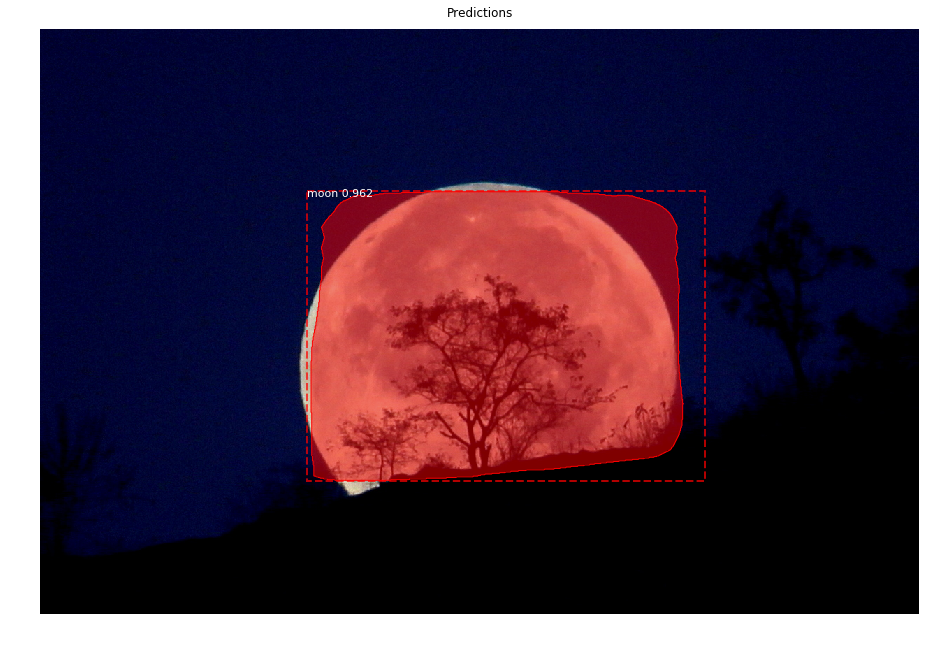

Processing 1 images
image                    shape: (105, 84, 3)          min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


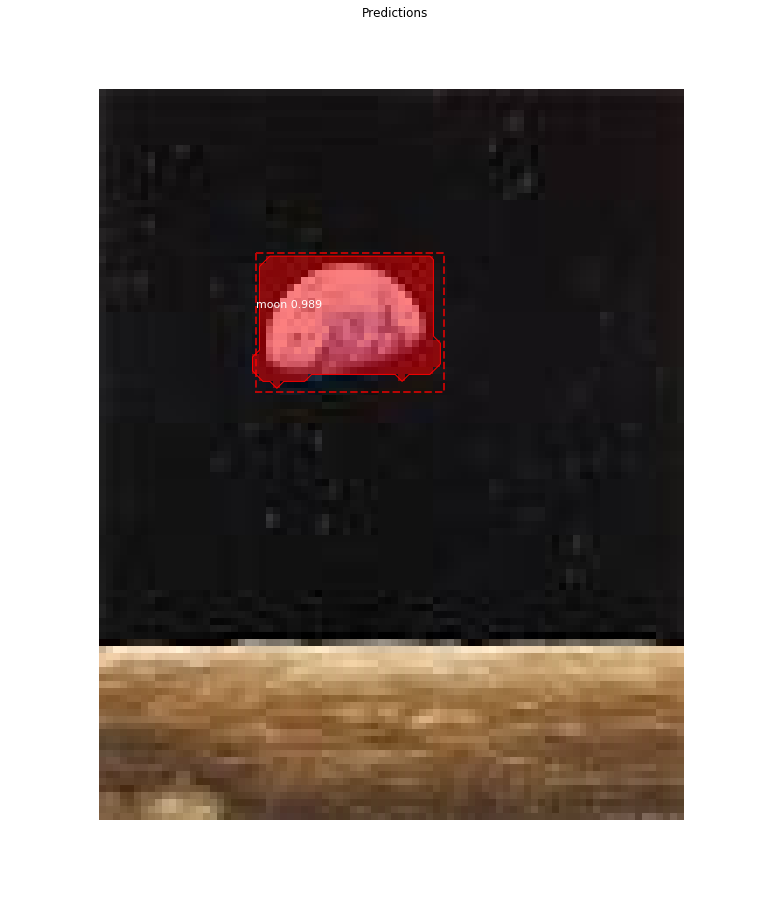

Processing 1 images
image                    shape: (1280, 1280, 3)       min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -122.07500  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1280.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


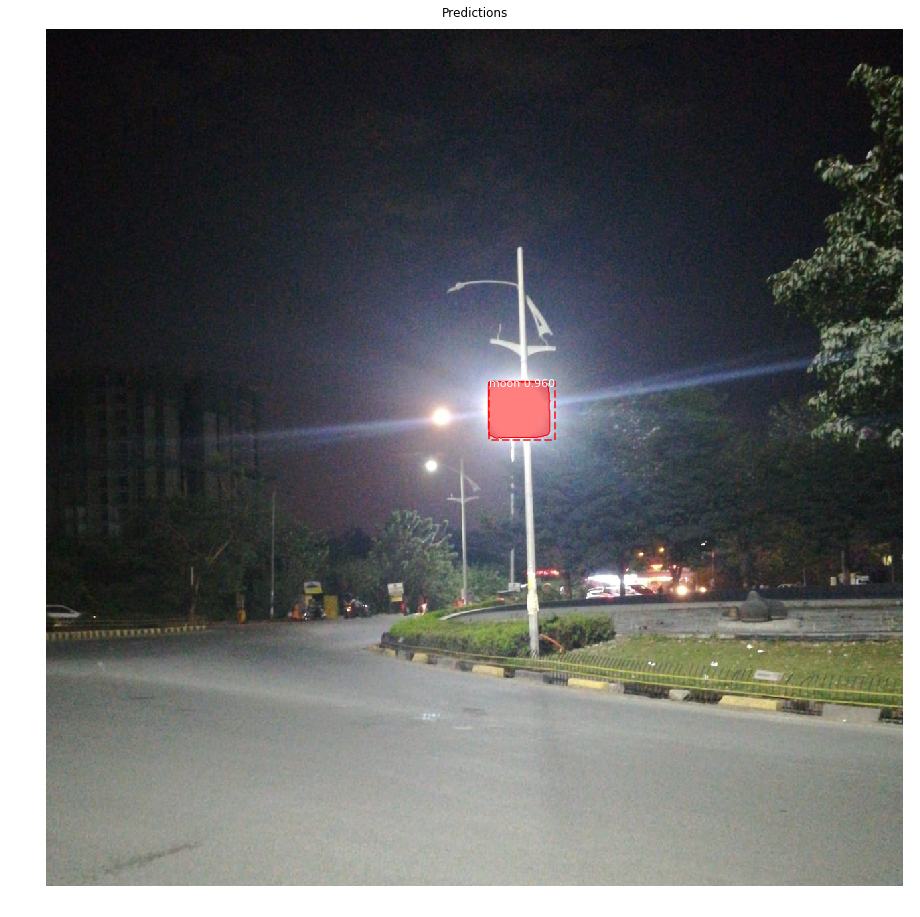

Processing 1 images
image                    shape: (84, 124, 3)          min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.13823  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


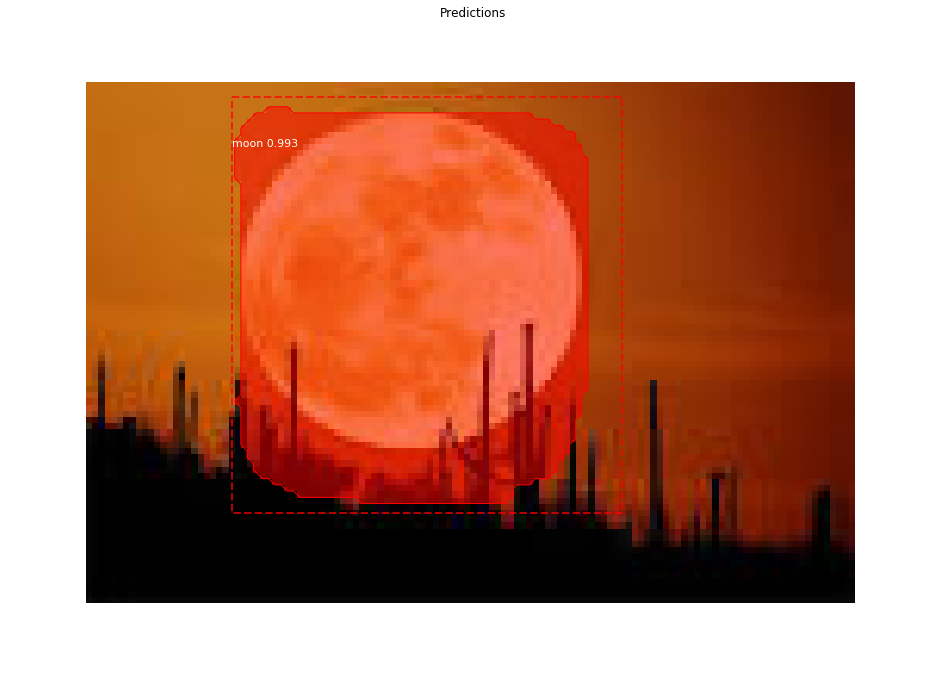

Processing 1 images
image                    shape: (168, 300, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


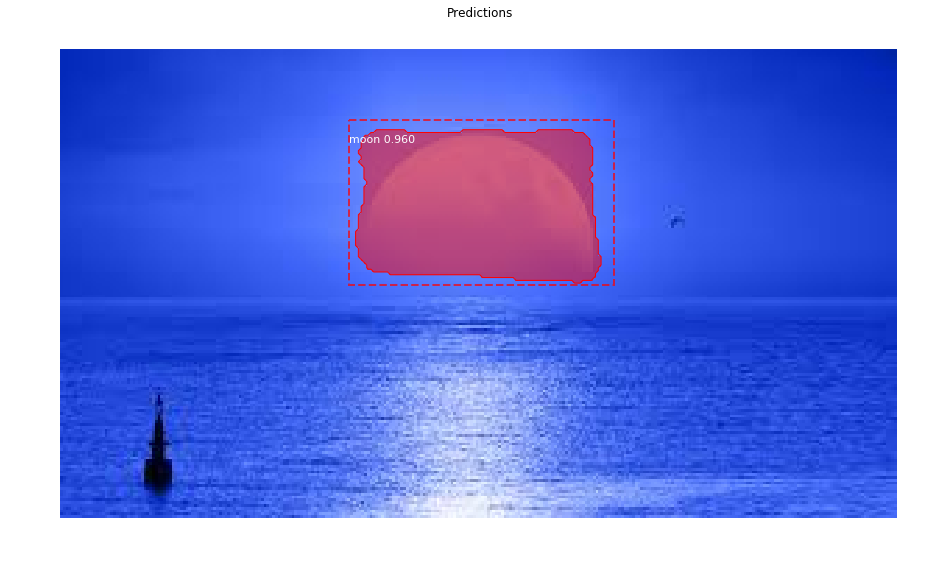

Processing 1 images
image                    shape: (690, 1176, 3)        min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1176.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


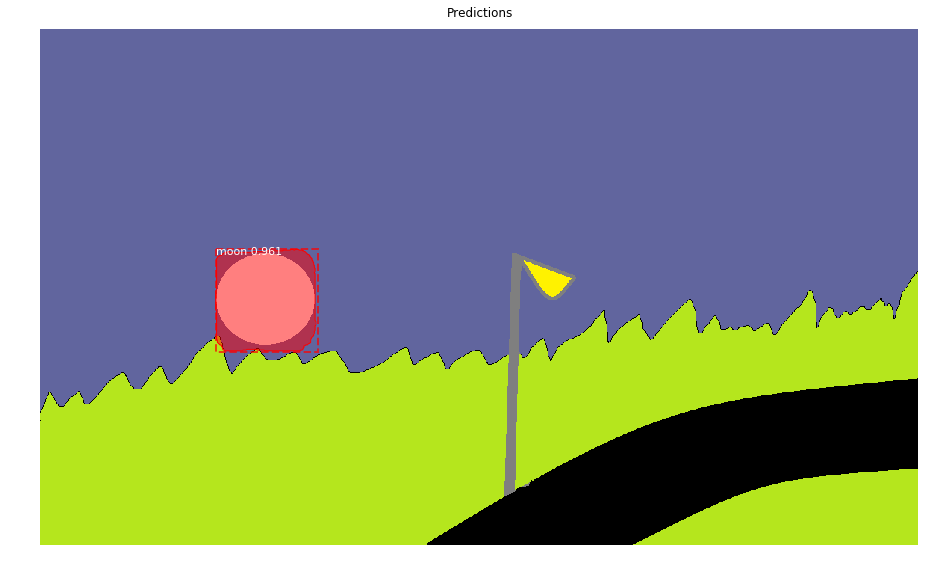

Processing 1 images
image                    shape: (180, 280, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  146.87242  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


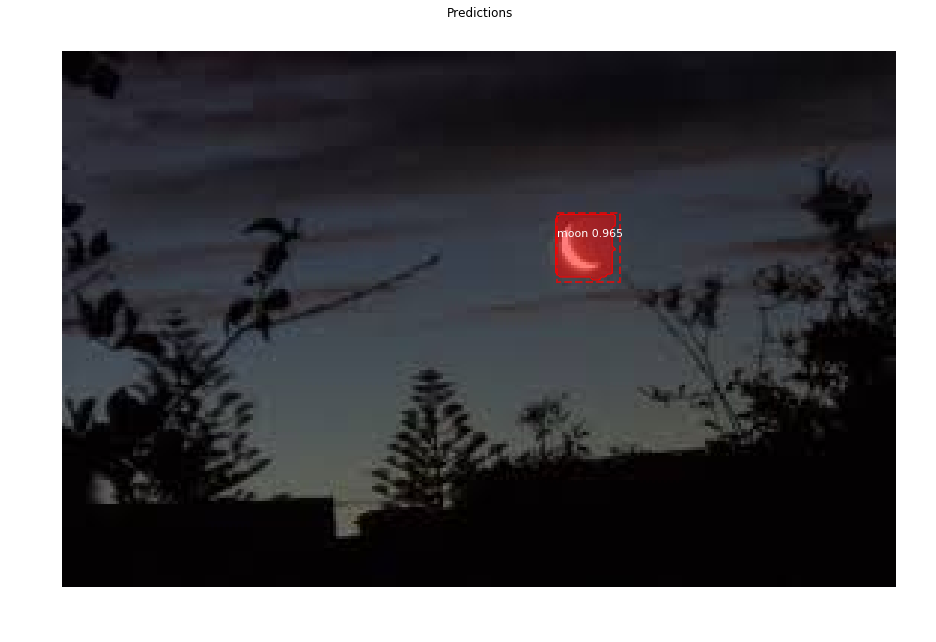

Processing 1 images
image                    shape: (188, 268, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  147.15403  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


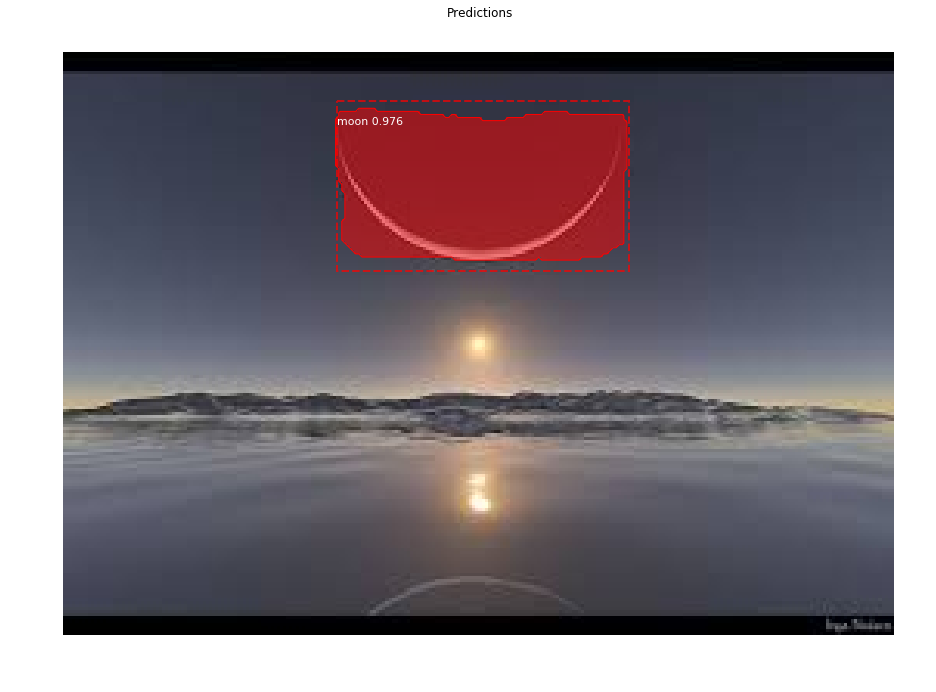

Processing 1 images
image                    shape: (84, 126, 3)          min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  136.52776  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


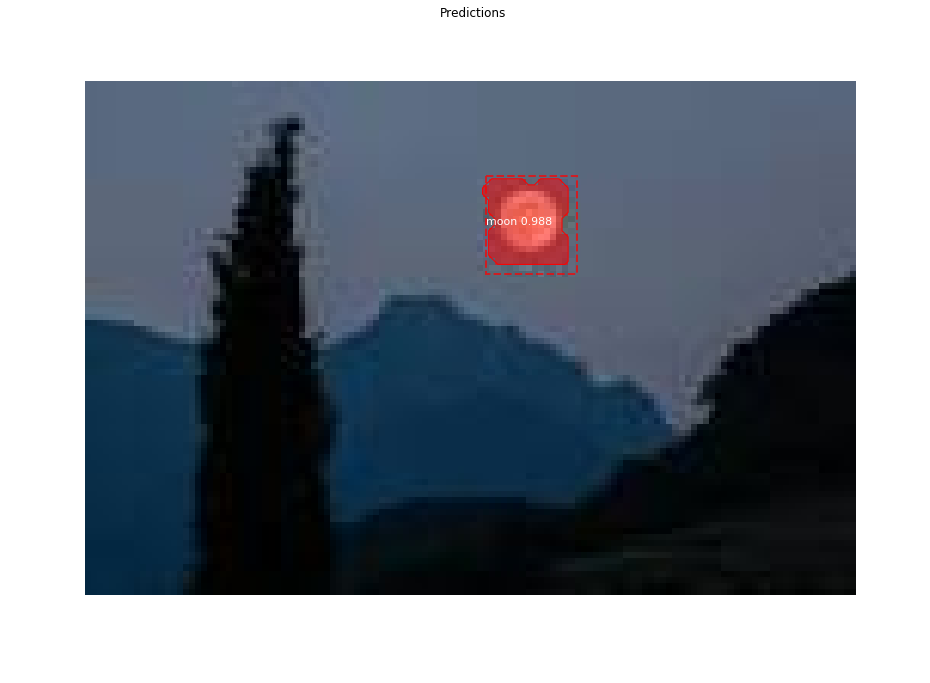

Processing 1 images
image                    shape: (259, 195, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  135.17766  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


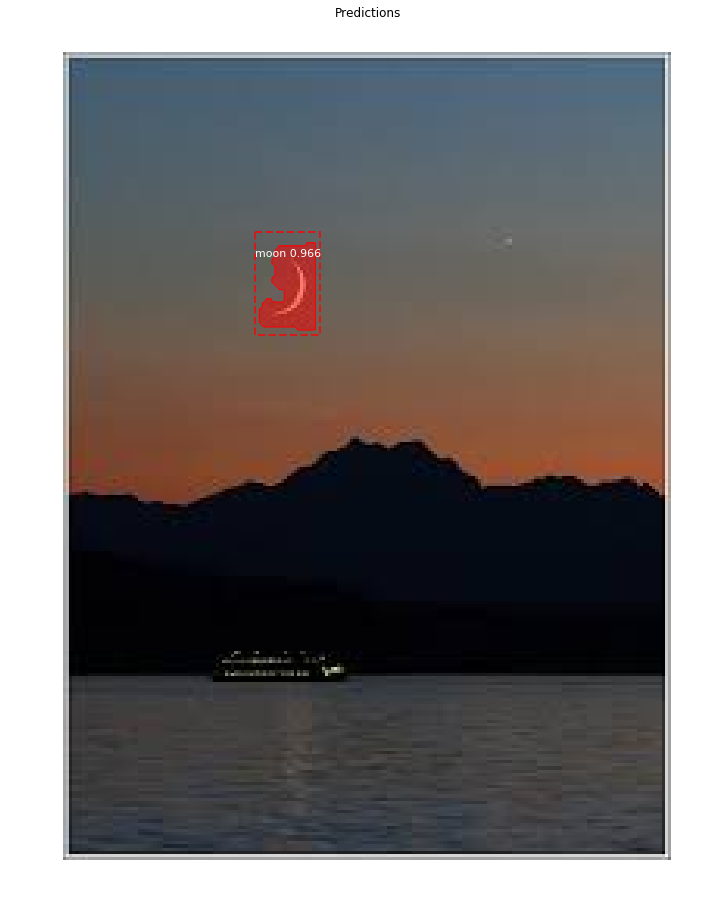

Processing 1 images
image                    shape: (183, 275, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.67469  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


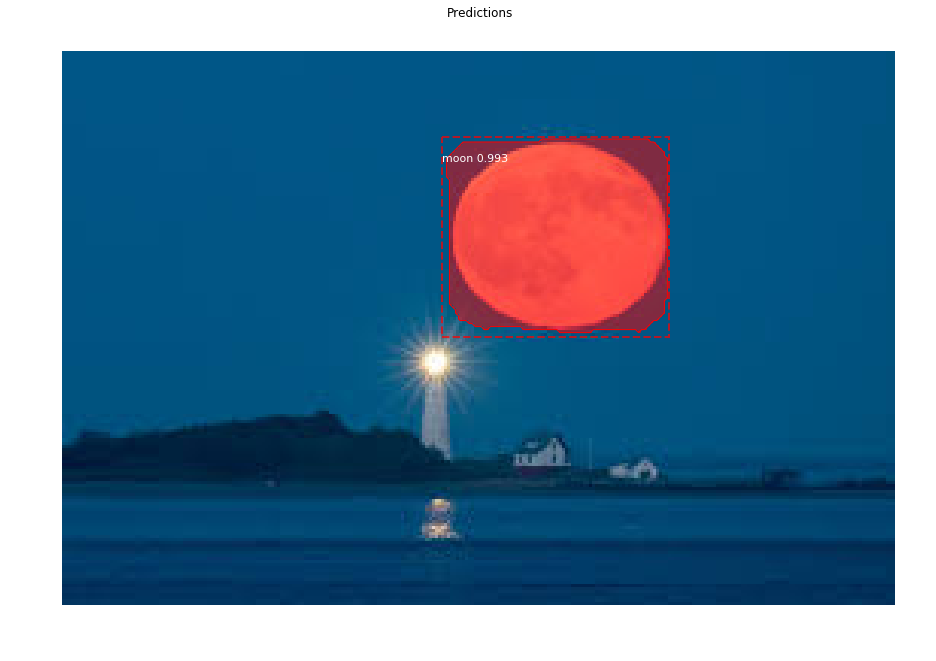

Processing 1 images
image                    shape: (511, 727, 3)         min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


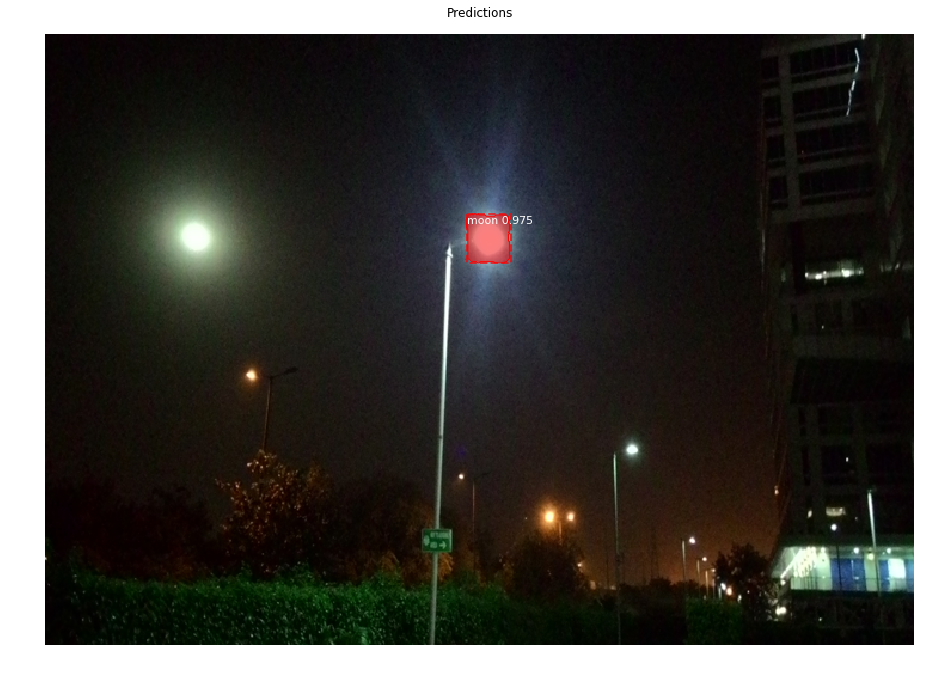

Processing 1 images
image                    shape: (690, 1176, 3)        min:    0.00000  max:  255.00000  float32
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1176.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


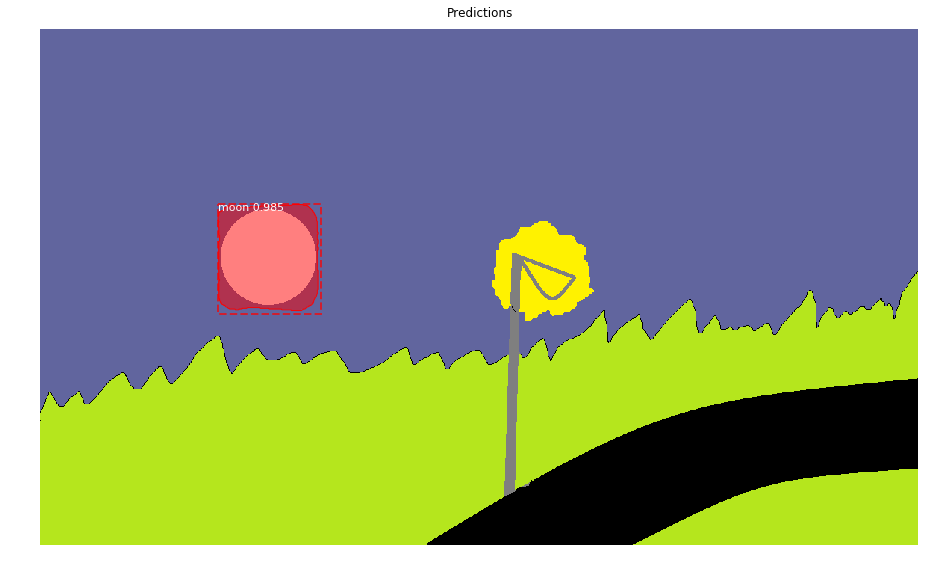

In [13]:
#random_image =   "test_images/" + random.choice(os.listdir("test_images/"))
#random_image =   "test_images/GIF/base - Copy (9).png"

input_path = "test_images/"

for i in os.listdir(input_path):

    img = load_img(input_path + i)
    img = img_to_array(img)
    # detecting objects in the image
    result= model.detect([img])

    # Run object detection
    results = model.detect([img], verbose=1)
    # Display results

    r = results[0]
    visualize.display_instances(img, r['rois'], r['masks'], r['class_ids'], 
                                test_set.class_names, r['scores'], 
                                title="Predictions")

    
    